In [41]:
#!pip install SPARQLWrapper
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install seaborn
#!pip install sparqlwrapper


In [42]:
from SPARQLWrapper import SPARQLWrapper

In [43]:
import os
import SPARQLWrapper 
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
%matplotlib inline

In [44]:
#endpoint = "http://localhost:9999/blazegraph/sparql" # SPARQL endpoint hosting ITO.owl
endpoint = "http://149.148.106.153:9999/blazegraph/sparql"
prefixes = """
PREFIX edam: <http://edamontology.org/>
PREFIX obo:  <http://purl.obolibrary.org/obo/>
PREFIX ito:  <https://identifiers.org/ito#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>

"""

def query(service, query, numeric_cols = []):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)
        
    df = pd.DataFrame(out, columns=cols)
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col])
    
    return df


In [45]:
DATA_DIR = 'data'
PLOT_DIR = 'plots'

In [46]:
file_dict = {}
for file in os.listdir(DATA_DIR):
    file_dict[(os.path.splitext(file)[0])] = os.path.join(DATA_DIR, file)

In [47]:
#file_dict

## General statistics

Based on ITO version from 13.07.2020.

In [48]:
from SPARQLWrapper import SPARQLWrapper, N3, JSON
from rdflib import Graph


In [32]:
#Select some papers
query = """

PREFIX edam: <http://edamontology.org/>
PREFIX obo:  <http://purl.obolibrary.org/obo/>
PREFIX ito:  <https://identifiers.org/ito#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>

SELECT ?paper ?date ?pwc ?label ?page  WHERE {
    ?paper a edam:data_0971 .
    ?paper obo:date ?date .
    ?paper ito:papers_with_code_id ?pwc .
    ?paper rdfs:label ?label .
    ?paper foaf:page ?page
}
ORDER BY ?date 
LIMIT 10
"""

sparql = SPARQLWrapper(endpoint)
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
result = sparql.query()
processed_results = json.load(result.response)

processed_results


{'head': {'vars': ['paper', 'date', 'pwc', 'label', 'page']},
 'results': {'bindings': [{'paper': {'type': 'uri',
     'value': 'https://identifiers.org/ito#ITO_10000'},
    'page': {'type': 'literal',
     'value': 'https://doi.org/10.1109/CIC.2000.898539'},
    'pwc': {'type': 'literal',
     'value': 'https://doi.org/10.1109/CIC.2000.898539'},
    'date': {'datatype': 'http://www.w3.org/2001/XMLSchema#date',
     'type': 'literal',
     'value': '2000-09-24'},
    'label': {'type': 'literal',
     'value': 'A method for detection of atrial fibrillation using RR intervals'}},
   {'paper': {'type': 'uri', 'value': 'https://identifiers.org/ito#ITO_16777'},
    'page': {'type': 'literal',
     'value': 'https://doi.org/10.1016/S0022-2836(03)00628-4'},
    'pwc': {'type': 'literal',
     'value': 'https://doi.org/10.1016/S0022-2836(03)00628-4'},
    'date': {'datatype': 'http://www.w3.org/2001/XMLSchema#date',
     'type': 'literal',
     'value': '2003-07-18'},
    'label': {'type': 'li

In [39]:
cols = processed_results['head']['vars']

out = []
for row in processed_results['results']['bindings']:
    item = []
    for c in cols:
        item.append(row.get(c, {}).get('value'))
    
    out.append(item)
        
df = pd.DataFrame(out, columns=cols)

df


,paper,date,pwc,label,page
0,https://identifiers.org/ito#ITO_10000,2000-09-24,https://doi.org/10.1109/CIC.2000.898539,A method for detection of atrial fibrillation ...,https://doi.org/10.1109/CIC.2000.898539
1,https://identifiers.org/ito#ITO_16777,2003-07-18,https://doi.org/10.1016/S0022-2836(03)00628-4,Distinguishing Enzyme Structures from Non-enzy...,https://doi.org/10.1016/S0022-2836(03)00628-4
2,https://identifiers.org/ito#ITO_12116,2005-01-01,http://citeseerx.ist.psu.edu/viewdoc/summary?d...,Support vector machine based arrhythmia classi...,http://citeseerx.ist.psu.edu/viewdoc/summary?d...
3,https://identifiers.org/ito#ITO_15836,2006-05-12,https://link.springer.com/chapter/10.1007/1188...,Consistent and elastic registration of histolo...,https://link.springer.com/chapter/10.1007/1188...
4,https://identifiers.org/ito#ITO_15832,2008-02-01,https://www.ncbi.nlm.nih.gov/pubmed/17659998,Symmetric diffeomorphic image registration wit...,https://www.ncbi.nlm.nih.gov/pubmed/17659998
5,https://identifiers.org/ito#ITO_16783,2009-04-16,http://proceedings.mlr.press/v5/shervashidze09...,Efficient graphlet kernels for large graph com...,http://proceedings.mlr.press/v5/shervashidze09...
6,https://identifiers.org/ito#ITO_04888,2010-03-01,https://doi.org/10.1007/s11263-008-0204-y,Twin gaussian processes for structured prediction,https://doi.org/10.1007/s11263-008-0204-y
7,https://identifiers.org/ito#ITO_05076,2010-11-30,https://doi.org/10.1002/sim.4067,Multiple imputation using chained equations: i...,https://doi.org/10.1002/sim.4067
8,https://identifiers.org/ito#ITO_15834,2011-08-15,https://www.ncbi.nlm.nih.gov/pubmed/21568711,Deformable medical image registration: setting...,https://www.ncbi.nlm.nih.gov/pubmed/21568711
9,https://identifiers.org/ito#ITO_03882,2012-02-13,http://arxiv.org/abs/1202.2745v1,Multi-column Deep Neural Networks for Image Cl...,http://arxiv.org/abs/1202.2745v1


In [24]:
out

[['https://identifiers.org/ito#ITO_10000',
  '2000-09-24',
  'https://doi.org/10.1109/CIC.2000.898539',
  'A method for detection of atrial fibrillation using RR intervals'],
 ['https://identifiers.org/ito#ITO_10000',
  '2000-09-24',
  'https://doi.org/10.1109/CIC.2000.898539',
  'A method for detection of atrial fibrillation using RR intervals'],
 ['https://identifiers.org/ito#ITO_10000',
  '2000-09-24',
  'https://doi.org/10.1109/CIC.2000.898539',
  'A method for detection of atrial fibrillation using RR intervals'],
 ['https://identifiers.org/ito#ITO_10000',
  '2000-09-24',
  'https://doi.org/10.1109/CIC.2000.898539',
  'A method for detection of atrial fibrillation using RR intervals'],
 ['https://identifiers.org/ito#ITO_16777',
  '2003-07-18',
  'https://doi.org/10.1016/S0022-2836(03)00628-4',
  'Distinguishing Enzyme Structures from Non-enzymes Without Alignments'],
 ['https://identifiers.org/ito#ITO_16777',
  '2003-07-18',
  'https://doi.org/10.1016/S0022-2836(03)00628-4',
  'Di

### Number of papers

In [49]:
qs = """
SELECT (COUNT(?paper) as ?paper_count) WHERE {
    ?paper a edam:data_0971 .
}
"""

total_number_of_papers = query(endpoint, prefixes + qs, ['paper_count'])
# save to csv
total_number_of_papers.to_csv(os.path.join(DATA_DIR, 'time_span_of_publications_covered_by_PWC.csv'), index=False)
total_number_of_papers.head()

,paper_count
0,7766


### Select Sample paper

In [51]:
#work on this
qs = """
SELECT (COUNT(?paper) as ?paper_count) WHERE {
    ?paper a edam:data_0971 .
}
"""

total_number_of_papers = query(endpoint, prefixes + qs, ['paper_count'])
# save to csv
total_number_of_papers.to_csv(os.path.join(DATA_DIR, 'time_span_of_publications_covered_by_PWC.csv'), index=False)
total_number_of_papers.head()

,paper_count
0,7766


### Number of papers that have at least one annotated metric

In [52]:
qs = """
SELECT (COUNT(DISTINCT ?paper) as ?paper_count) WHERE {
    ?paper a edam:data_0971 . 
    ?benchmark_process_individual rdfs:seeAlso ?paper . 
    ?benchmark_process_individual ?performance_measure ?result .
    ?performance_measure rdfs:subPropertyOf* ito:performance_measure .
}
"""

number_of_papers_that_have_at_least_one_annotated_metric = query(endpoint, prefixes + qs, ['paper_count'])
# save to csv
number_of_papers_that_have_at_least_one_annotated_metric.to_csv(os.path.join(DATA_DIR, 'number_of_papers_that_have_at_least_one_annotated_metric.csv'), index=False)
number_of_papers_that_have_at_least_one_annotated_metric.head()

,paper_count
0,3867


### Total number of benchmark datasets

In [161]:
qs = """
SELECT (COUNT(?benchmark) as ?benchmark_count) WHERE {
    ?benchmark rdfs:subClassOf ito:Benchmarking
}
"""

total_number_of_benchmarks = query(endpoint, prefixes + qs, ['benchmark_count'])
# save to csv
total_number_of_benchmarks.to_csv(os.path.join(DATA_DIR, 'total_number_of_benchmarks.csv'), index=False)
total_number_of_benchmarks.head()

,benchmark_count
0,2298


In [162]:
number_of_benchmark_datasets = total_number_of_benchmarks.benchmark_count[0]

### Time span of publications covered by PWC

In [163]:
qs = """
SELECT ?paper ?date WHERE {
    ?paper a edam:data_0971 .
    ?paper <http://purl.obolibrary.org/obo/date> ?date
}
ORDER BY ?date
"""

time_span_of_publications_covered_by_PWC = query(endpoint, prefixes + qs)

# save to csv
time_span_of_publications_covered_by_PWC.to_csv(os.path.join(DATA_DIR, 'time_span_of_publications_covered_by_PWC.csv'), index=False)

# Convert 'date' column to datetime
time_span_of_publications_covered_by_PWC['date'] = pd.to_datetime(time_span_of_publications_covered_by_PWC['date'])


In [164]:
# Add extra columns for week/year and year
#time_span_of_publications_covered_by_PWC['week/year'] = time_span_of_publications_covered_by_PWC['date'].apply(lambda x: "%d/%d" % (x.week, x.year))
time_span_of_publications_covered_by_PWC['year'] = time_span_of_publications_covered_by_PWC['date'].apply(lambda x: "%d" % (x.year))

In [165]:
time_span_of_publications_covered_by_PWC_grouped_by_year = time_span_of_publications_covered_by_PWC.groupby('year').size()
#time_span_of_publications_covered_by_PWC_grouped_by_year

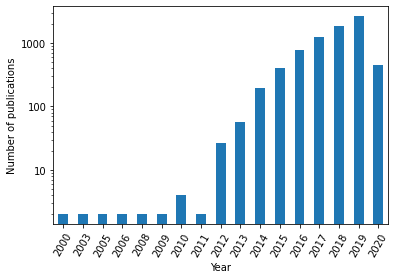

In [166]:
ax = time_span_of_publications_covered_by_PWC_grouped_by_year.plot.bar(x='lab', y='val', rot=60)
ax.set(ylabel='Number of publications', xlabel='Year')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ScalarFormatter())

# Save figure
plt.savefig('plots/time_span_of_publications.png', format='png')

## Statistics per high level process

### Number of total metric reports per high level process

In [167]:
qs = """
SELECT ?high_level_process_label ?high_level_process
       (COUNT(?subprocess_performance_measure) AS ?subprocess_performance_measure_count)
WHERE {
    ?high_level_process rdfs:subClassOf ito:Process ;
                        rdfs:label ?high_level_process_label . 

    ?subprocess rdfs:subClassOf* ?high_level_process .

    ?subprocess rdfs:subClassOf ?property_restriction .
    ?property_restriction owl:onProperty ?subprocess_performance_measure .
    ?subprocess_performance_measure rdfs:subPropertyOf* ito:performance_measure .
}
GROUP BY ?high_level_process_label ?high_level_process
ORDER BY DESC(?subprocess_performance_measure_count)
"""

number_of_metrics_aggregated_by_high_level_process = query(endpoint, prefixes + qs, ['subprocess_performance_measure_count'])

# save to csv
number_of_metrics_aggregated_by_high_level_process.to_csv(os.path.join(DATA_DIR, 'number_of_metrics_aggregated_by_high_level_process.csv'), index=False)


number_of_metrics_aggregated_by_high_level_process.head()

,high_level_process_label,high_level_process,subprocess_performance_measure_count
0,AI process,https://identifiers.org/ito#ITO_01625,21984
1,Knowledge creation process,https://identifiers.org/ito#ITO_01626,21984
2,Bioinformatics operation,http://edamontology.org/operation_0004,330


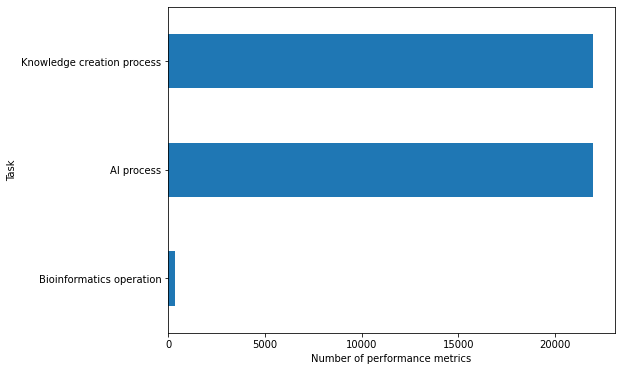

In [168]:
ax = number_of_metrics_aggregated_by_high_level_process.head(20).sort_values(by='subprocess_performance_measure_count').plot.barh(x='high_level_process_label', y='subprocess_performance_measure_count', rot=0, figsize=(8, 6), legend=None)
ax.set(ylabel='Task', xlabel='Number of performance metrics')

# Save figure
plt.savefig('plots/number_of_total_metric_reports_per_high_level_process.png', format='png')

### Number of benchmark datasets per high level process

In [53]:
qs = """
SELECT ?high_level_process_label ?high_level_process
       (COUNT(?benchmark) AS ?benchmark_count)
WHERE {
    ?high_level_process rdfs:subClassOf ito:Process ;
                        rdfs:label ?high_level_process_label . 

    ?benchmark rdfs:subClassOf ito:Benchmarking . 
    ?benchmark rdfs:subClassOf* ?high_level_process .
}
GROUP BY ?high_level_process_label ?high_level_process
ORDER BY DESC(?benchmark_count)
"""

number_of_benchmarks_per_high_level_process = query(endpoint, prefixes + qs, ['benchmark_count'])

# save to csv
number_of_benchmarks_per_high_level_process.to_csv(os.path.join(DATA_DIR, 'number_of_benchmarks_per_high_level_process.csv'), index=False)



In [54]:

# Remove task 'Segmentation process' and 'benchmarking'
#This is not returnin the position 0,6
#number_of_benchmarks_per_high_level_process = number_of_benchmarks_per_high_level_process.drop(index=[0,6])
number_of_benchmarks_per_high_level_process.head()  

,high_level_process_label,high_level_process,benchmark_count
0,AI process,https://identifiers.org/ito#ITO_01625,2298
1,Knowledge creation process,https://identifiers.org/ito#ITO_01626,2298
2,Bioinformatics operation,http://edamontology.org/operation_0004,24


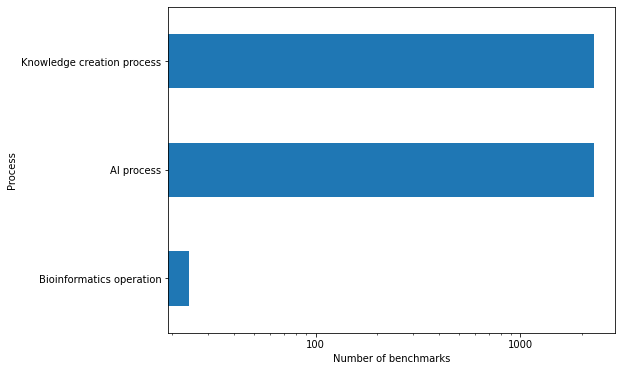

In [171]:
ax = number_of_benchmarks_per_high_level_process.sort_values(by='benchmark_count').plot.barh(x='high_level_process_label', y='benchmark_count', rot=0, figsize=(8, 6), legend=None)
ax.set(ylabel='Process', xlabel='Number of benchmarks')
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())

# Save figure
plt.savefig('plots/number_of_benchmark_datasets_per_high_level_process.png', format='png')

## Statistics on top-level metrics

### Total reports per top-level metric

In [172]:
qs = """
SELECT ?performance_measure_label ?performance_measure
       (COUNT(?benchmark_process_indivdual_in_subproperty) AS ?benchmark_process_individual_in_subproperty_count)
WHERE {
    ?performance_measure rdfs:subPropertyOf ito:performance_measure ;
                         rdfs:label ?performance_measure_label .
    ?performance_measure_subproperty rdfs:subPropertyOf* ?performance_measure .
    ?benchmark_process_indivdual_in_subproperty ?performance_measure_subproperty ?result_s .
}

GROUP BY ?performance_measure_label ?performance_measure
ORDER BY DESC(?benchmark_process_individual_in_subproperty_count)
"""

suproperty_statistics_per_benchmark = query(endpoint, prefixes + qs, ['benchmark_process_individual_in_subproperty_count'])

# save to csv
suproperty_statistics_per_benchmark.to_csv(os.path.join(DATA_DIR, 'total_reports_per_toplevel_metric.csv'), index=False)

suproperty_statistics_per_benchmark.head(10)

,performance_measure_label,performance_measure,benchmark_process_individual_in_subproperty_count
0,Accuracy,https://identifiers.org/ito#ITO_01157,12061
1,Score,https://identifiers.org/ito#ITO_08816,3752
2,Precision,https://identifiers.org/ito#ITO_04547,3526
3,F-measure,https://identifiers.org/ito#ITO_01609,2115
4,Peak signal-to-noise ratio,https://identifiers.org/ito#ITO_00016,944
5,Intersection over Union,https://identifiers.org/ito#ITO_00024,921
6,Structural similarity index,https://identifiers.org/ito#ITO_00045,685
7,Hits-at-k,https://identifiers.org/ito#ITO_00002,553
8,Exact match,https://identifiers.org/ito#ITO_01569,465
9,R-at-K,https://identifiers.org/ito#ITO_00082,427


### Number of benchmark datasets per top-level metric

In [48]:
qs = """
SELECT ?performance_measure_label ?performance_measure
       (COUNT(?benchmark) AS ?benchmark_count)
WHERE {
    ?performance_measure rdfs:subPropertyOf ito:performance_measure ;
                         rdfs:label ?performance_measure_label .
    ?performance_measure_subproperty rdfs:subPropertyOf* ?performance_measure .
    ?benchmark rdfs:subClassOf ?property_restriction .
    ?property_restriction owl:onProperty ?performance_measure_subproperty
}
GROUP BY ?performance_measure_label ?performance_measure
ORDER BY DESC(?benchmark_count)
"""

top_level_metrics_per_benchmark = query(endpoint, prefixes + qs, ['benchmark_count'])

# save to csv
top_level_metrics_per_benchmark.to_csv(os.path.join(DATA_DIR, 'benchmark_datasets_per_toplevel_metric.csv'), index=False)


top_level_metrics_per_benchmark.head()

,performance_measure_label,performance_measure,benchmark_count
0,Accuracy,https://identifiers.org/ito#ITO_01157,930
1,F-measure,https://identifiers.org/ito#ITO_01609,393
2,Precision,https://identifiers.org/ito#ITO_04547,382
3,R-at-K,https://identifiers.org/ito#ITO_00082,143
4,Intersection over Union,https://identifiers.org/ito#ITO_00024,115


In [49]:
# Remove 'NEW' string from performance_measure_label column for plotting
edited_strings = [i.rstrip(' NEW') for i in top_level_metrics_per_benchmark['performance_measure_label']]
top_level_metrics_per_benchmark.performance_measure_label = edited_strings
# Remove 'Undetermined'
top_level_metrics_per_benchmark = top_level_metrics_per_benchmark[top_level_metrics_per_benchmark.performance_measure_label != 'Undetermined']

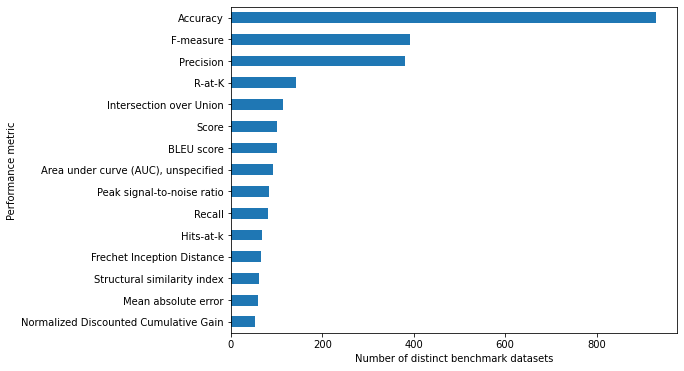

In [50]:
ax = top_level_metrics_per_benchmark.head(15).sort_values(by='benchmark_count').plot.barh(x='performance_measure_label', y='benchmark_count', rot=0, figsize=(8, 6), legend=None)
ax.set(ylabel='Performance metric', xlabel='Number of distinct benchmark datasets')

# Save figure
plt.savefig('plots/number_of_benchmark_datasets_per_toplevel_metric.png', format='png')

### Number of different top-level metrics per benchmark dataset

In [51]:
qs = """
SELECT  ?benchmark_label ?benchmark
       (COUNT(DISTINCT ?performance_measure) AS ?performance_measure_count)
       (GROUP_CONCAT(DISTINCT ?performance_measure_label;SEPARATOR=";") AS ?performance_measure_labels)
WHERE {
    {
        ?performance_measure rdfs:subPropertyOf ito:performance_measure ;
                         rdfs:label ?performance_measure_label .
    }
    UNION
    {
        ?performance_measure rdfs:subPropertyOf* ?performance_measure_topmost .
        ?performance_measure_topmost rdfs:subPropertyOf ito:performance_measure ;
                         rdfs:label ?performance_measure_label .
    }
    ?benchmark rdfs:subClassOf ito:Benchmarking ;
              rdfs:label ?benchmark_label ;
              rdfs:subClassOf ?property_restriction .
    ?property_restriction owl:onProperty ?performance_measure .
}
GROUP BY ?benchmark_label ?benchmark
ORDER BY DESC(?performance_measure_count)
"""

number_of_different_metrics_per_benchmark_superproperties = query(endpoint, prefixes + qs, ['performance_measure_count'])

# save to csv
number_of_different_metrics_per_benchmark_superproperties.to_csv(os.path.join(DATA_DIR, 'number_of_different_toplevel_metrics_per_benchmark_dataset.csv'), index=False)

number_of_different_metrics_per_benchmark_superproperties.head()

,benchmark_label,benchmark,performance_measure_count,performance_measure_labels
0,MSR-VTT - Video Retrieval benchmarking,https://identifiers.org/ito#ITO_07273,10,R-at-K
1,COCO test-dev - Keypoint Detection benchmarking,https://identifiers.org/ito#ITO_11334,10,Precision;Recall
2,RCV1 - Text Classification benchmarking,https://identifiers.org/ito#ITO_14703,9,P-at-K;Accuracy;Normalized Discounted Cumulati...
3,"MIT-States, generalized split - Compositional ...",https://identifiers.org/ito#ITO_07763,9,"Area under curve (AUC), unspecified;Accuracy;F..."
4,COCO test-challenge - Keypoint Detection bench...,https://identifiers.org/ito#ITO_11367,9,Precision;Recall


In [52]:
# Count number of distinct performance measure labels
distinct_counts = [len(i.split(";")) for i in number_of_different_metrics_per_benchmark_superproperties['performance_measure_labels']]

#### How often are accuracy and F1 used in isolation?

In [53]:
number_of_different_metrics_per_benchmark_superproperties['performance_measure_labels'].str.contains('Accuracy').value_counts()

False    1490
True      808
Name: performance_measure_labels, dtype: int64

In [54]:
number_of_different_metrics_per_benchmark_superproperties.query('performance_measure_labels == "Accuracy"').count()

benchmark_label               654
benchmark                     654
performance_measure_count     654
performance_measure_labels    654
dtype: int64

In [55]:
# needs to be edited #????
number_of_different_metrics_per_benchmark_superproperties['performance_measure_labels'].str.contains("F-measure NEW").value_counts()

False    2298
Name: performance_measure_labels, dtype: int64

In [56]:
# needs to be edited #????
number_of_different_metrics_per_benchmark_superproperties.query('performance_measure_labels == "F-measure NEW"').count()

benchmark_label               0
benchmark                     0
performance_measure_count     0
performance_measure_labels    0
dtype: int64

In [57]:
# add distinct count column
number_of_different_metrics_per_benchmark_superproperties_distinct = number_of_different_metrics_per_benchmark_superproperties.assign(distinct_performance_measure_count=lambda x: [i for i in distinct_counts])
number_of_different_metrics_per_benchmark_superproperties_distinct= number_of_different_metrics_per_benchmark_superproperties_distinct.sort_values(by='distinct_performance_measure_count', ascending=False)
number_of_different_metrics_per_benchmark_superproperties_distinct.head()

,benchmark_label,benchmark,performance_measure_count,performance_measure_labels,distinct_performance_measure_count
27,NTU Hand Digit - Gesture-to-Gesture Translatio...,https://identifiers.org/ito#ITO_11038,6,Peak signal-to-noise ratio;Inception Score;Und...,6
26,Senz3D - Gesture-to-Gesture Translation benchm...,https://identifiers.org/ito#ITO_11027,6,Peak signal-to-noise ratio;Inception Score;Und...,6
50,E2E NLG Challenge - Data-to-Text Generation be...,https://identifiers.org/ito#ITO_09083,5,METEOR;NIST;Consensus-based Image Description ...,5
34,S3DIS - 3D Instance Segmentation benchmarking,https://identifiers.org/ito#ITO_16148,6,Intersection over Union;Recall;Precision;Accur...,5
17,ImageNet 64x64 - Image Generation benchmarking,https://identifiers.org/ito#ITO_05884,6,Bits per byte;Inception Score;Bits per dimensi...,5


In [58]:
number_of_different_metrics_per_benchmark_superproperties_distinct_grouped = number_of_different_metrics_per_benchmark_superproperties_distinct.groupby('distinct_performance_measure_count').size()
number_of_different_metrics_per_benchmark_superproperties_distinct_grouped

distinct_performance_measure_count
1    1777
2     345
3     132
4      33
5       9
6       2
dtype: int64

In [59]:
number_of_different_metrics_per_benchmark_superproperties_distinct_grouped.sum()

2298

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Number of distinct performance metrics per benchmark')]

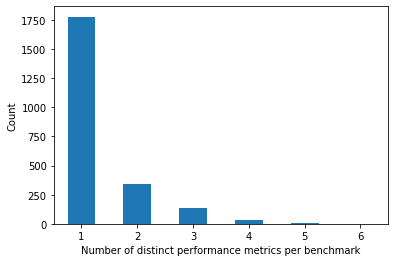

In [60]:
ax = number_of_different_metrics_per_benchmark_superproperties_distinct_grouped.plot.bar(x='high_level_process_label', y='subprocess_performance_measure_count', rot=0, figsize=(6, 4))
ax.set(ylabel='Count', xlabel='Number of distinct performance metrics per benchmark')

In [62]:
different_metrics_per_benchmark_superproperties_distinct = number_of_different_metrics_per_benchmark_superproperties_distinct['performance_measure_labels'].str.split(";", expand = True)
different_metrics_per_benchmark_superproperties_one_hot = pd.get_dummies(different_metrics_per_benchmark_superproperties_distinct, prefix='', prefix_sep='').groupby(level=0, axis=1).sum()

cooccurrence_matrix = different_metrics_per_benchmark_superproperties_one_hot.T.dot(different_metrics_per_benchmark_superproperties_one_hot)
cooccurrence_matrix .values[[np.arange(cooccurrence_matrix.shape[0])]*2] = 0

cooccurrence_matrix
#maybe plot some heatmap here

<ipython-input-62-47e10604fd4c>:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cooccurrence_matrix .values[[np.arange(cooccurrence_matrix.shape[0])]*2] = 0


,3D percentage of correct keypoints,Absolute relative error,Accuracy,Adjusted Rand Index,Angular Error,Apnea-hypopnoea index,"Area under curve (AUC), unspecified",Average 3D Error,Average 3D distance of model points,Average Distance Error,...,User rating,Value of Information,Variation of information,Vertex-to-vertex metric,Visual surface similarity,Volume similarity,Warping Error,Weighted average precision,Word Error Rate,nuScenes detection score
3D percentage of correct keypoints,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Absolute relative error,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Accuracy,0,0,0,2,0,1,16,0,3,0,...,0,0,0,0,0,0,0,2,0,0
Adjusted Rand Index,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Angular Error,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Volume similarity,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Warping Error,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Weighted average precision,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Word Error Rate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#cooccurrence_matrix['F1 score NEW']

In [63]:
# Appearing together >10 times
cooccurrence_matrix = cooccurrence_matrix[(cooccurrence_matrix > 10).any()]
#cooccurrence_matrix

In [64]:
# Drop all zero entries
#cooccurrence_matrix = cooccurrence_matrix[(cooccurrence_matrix.T != 0).any()]

### Match metrics with metric types

In [65]:
top_level_metrics_per_benchmark_associated_tasks = pd.read_csv('data/top_level_metrics_per_benchmark_including_associated_tasks.csv', sep=';')
top_level_metrics_per_benchmark_associated_tasks.head()

,performance_measure_label,associated_task_type_1
0,Accuracy,Classification
1,Score,Game Playing
2,Precision,Classification
3,F-measure,Classification
4,Peak signal-to-noise ratio,Computer vision


In [66]:
# Merge dataframes with counts and task types
top_level_metrics_per_benchmark_and_associated_tasks = pd.merge(top_level_metrics_per_benchmark, top_level_metrics_per_benchmark_associated_tasks, on='performance_measure_label')

In [67]:
top_level_metrics_per_benchmark_and_associated_tasks.head()

# save to csv
top_level_metrics_per_benchmark_and_associated_tasks.to_csv(os.path.join(DATA_DIR, 'top_level_metrics_per_benchmark_and_associated_tasks.csv'), index=False)


In [68]:
top_level_metrics_per_benchmark_associated_tasks.head()

,performance_measure_label,associated_task_type_1
0,Accuracy,Classification
1,Score,Game Playing
2,Precision,Classification
3,F-measure,Classification
4,Peak signal-to-noise ratio,Computer vision


### Individual benchmark count per top-level metric type

In [69]:
toplevel_metrics_per_benchmark_dataset = pd.concat([number_of_different_metrics_per_benchmark_superproperties_distinct.iloc[:,0], number_of_different_metrics_per_benchmark_superproperties_distinct['performance_measure_labels'].str.split(";", expand = True)], axis=1)

In [70]:
toplevel_metrics_per_benchmark_dataset_long = pd.melt(toplevel_metrics_per_benchmark_dataset, id_vars=['benchmark_label'], var_name='number', value_name='performance_measure_label')
toplevel_metrics_per_benchmark_dataset_long = toplevel_metrics_per_benchmark_dataset_long.dropna()

toplevel_metrics_per_benchmark_dataset_long = toplevel_metrics_per_benchmark_dataset_long.replace(to_replace =' NEW', value = '', regex = True)

#test_df_long = test_df_long[test_df_long.performance_measure_label != 'Undetermined']
toplevel_metrics_per_benchmark_dataset_long = toplevel_metrics_per_benchmark_dataset_long.drop('number', axis=1)
toplevel_metrics_per_benchmark_dataset_long = toplevel_metrics_per_benchmark_dataset_long.drop_duplicates()
toplevel_metrics_per_benchmark_dataset_long = toplevel_metrics_per_benchmark_dataset_long.reset_index(drop=True)
toplevel_metrics_per_benchmark_dataset_long.head()

,benchmark_label,performance_measure_label
0,NTU Hand Digit - Gesture-to-Gesture Translatio...,Peak signal-to-noise ratio
1,Senz3D - Gesture-to-Gesture Translation benchm...,Peak signal-to-noise ratio
2,E2E NLG Challenge - Data-to-Text Generation be...,METEOR
3,S3DIS - 3D Instance Segmentation benchmarking,Intersection over Union
4,ImageNet 64x64 - Image Generation benchmarking,Bits per byte


In [71]:
toplevel_metrics_per_benchmark_dataset_long_merged = pd.merge(toplevel_metrics_per_benchmark_dataset_long, top_level_metrics_per_benchmark_associated_tasks, on='performance_measure_label')
toplevel_metrics_per_benchmark_dataset_long_merged = toplevel_metrics_per_benchmark_dataset_long_merged.drop_duplicates()
toplevel_metrics_per_benchmark_dataset_long_merged.head()

,benchmark_label,performance_measure_label,associated_task_type_1
0,NTU Hand Digit - Gesture-to-Gesture Translatio...,Peak signal-to-noise ratio,Computer vision
1,Senz3D - Gesture-to-Gesture Translation benchm...,Peak signal-to-noise ratio,Computer vision
2,FFHQ - Facial Inpainting benchmarking,Peak signal-to-noise ratio,Computer vision
3,DIV2K val - 2x upscaling - Image Super-Resolut...,Peak signal-to-noise ratio,Computer vision
4,LOL - Low-Light Image Enhancement benchmarking,Peak signal-to-noise ratio,Computer vision


In [72]:
distinct_benchmark_count_per_metric_type = toplevel_metrics_per_benchmark_dataset_long_merged.groupby(['associated_task_type_1', 'benchmark_label']).nunique()
distinct_benchmark_count_per_metric_type = distinct_benchmark_count_per_metric_type.iloc[:,0:1].groupby('associated_task_type_1').sum()
distinct_benchmark_count_per_metric_type.columns = ['benchmark_count']

### Distribution of metrics usually used for classification, regression and other tasks

In [73]:

top_level_metrics_per_benchmark_and_associated_tasks.head()

,performance_measure_label,performance_measure,benchmark_count,associated_task_type_1
0,Accuracy,https://identifiers.org/ito#ITO_01157,930,Classification
1,F-measure,https://identifiers.org/ito#ITO_01609,393,Classification
2,Precision,https://identifiers.org/ito#ITO_04547,382,Classification
3,R-at-K,https://identifiers.org/ito#ITO_00082,143,Classification
4,Intersection over Union,https://identifiers.org/ito#ITO_00024,115,Classification


In [74]:
frequency_per_task_type = top_level_metrics_per_benchmark_and_associated_tasks.iloc[:,-2:].groupby('associated_task_type_1').count()
frequency_per_task_type.columns = ['Number of metrics']
frequency_per_task_type.sort_values('Number of metrics', ascending=False)

,Number of metrics
associated_task_type_1,
Computer vision,63
Other,40
Classification,28
Natural language processing,25
Regression,12
Ranking,4
Clustering,3
Game Playing,3


In [75]:
distinct_benchmark_count_per_metric_type

,benchmark_count
associated_task_type_1,
Classification,1921
Clustering,33
Computer vision,358
Game Playing,105
Natural language processing,203
Other,141
Ranking,75
Regression,153


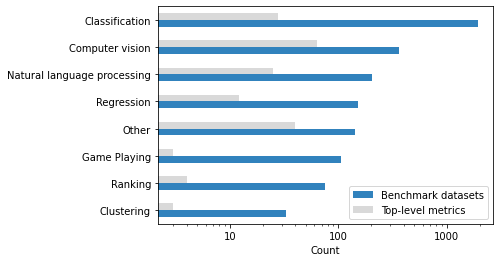

In [76]:
figsize=(12,4)

df = pd.DataFrame.merge(distinct_benchmark_count_per_metric_type, frequency_per_task_type, on='associated_task_type_1')
ax = df.sort_values(by='benchmark_count', ascending=True).plot.barh(rot=0, cmap='tab20c')
ax.set(xlabel='Count')
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_label_text("")
ax.legend(['Benchmark datasets', 'Top-level metrics', ])

# Save figure
plt.savefig('plots/comparison_number_of_benchmark_datasets_and_number_of_toplevel_metrics_per_type.png', format='png')

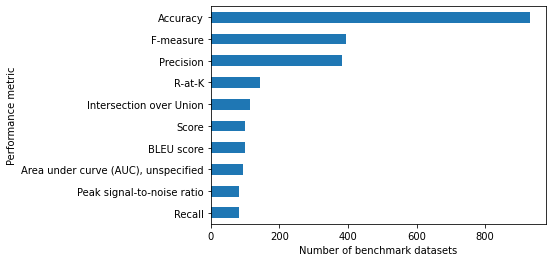

In [77]:
ax = top_level_metrics_per_benchmark_and_associated_tasks.head(10).sort_values(by='benchmark_count').plot.barh(x='performance_measure_label', y='benchmark_count', rot=0, figsize=(6, 4), legend=None)
ax.set(ylabel='Performance metric', xlabel='Number of benchmark datasets')

# Save figure
plt.savefig('plots/number_of_benchmark_datasets_per_toplevel_metrics.png', format='png')

In [78]:
frequency_per_task_type

,Number of metrics
associated_task_type_1,
Classification,28
Clustering,3
Computer vision,63
Game Playing,3
Natural language processing,25
Other,40
Ranking,4
Regression,12


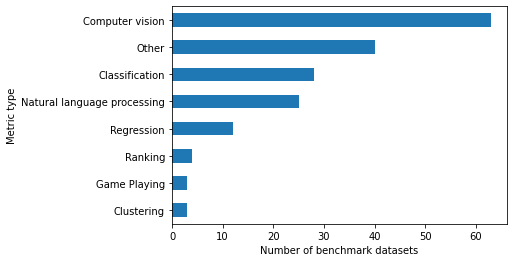

In [79]:
ax = frequency_per_task_type.sort_values(by='Number of metrics', ascending=True).plot.barh(rot=0, figsize=(6, 4), legend=None)
ax.set(ylabel='Metric type', xlabel='Number of benchmark datasets')

# Save figure
plt.savefig('plots/number_of_benchmark_datasets_per_metric_type.png', format='png')

### Classification

In [80]:
top_level_metrics_per_benchmark_classification = top_level_metrics_per_benchmark_and_associated_tasks[top_level_metrics_per_benchmark_and_associated_tasks.associated_task_type_1 == 'Classification']
top_level_metrics_per_benchmark_classification.head(10)

,performance_measure_label,performance_measure,benchmark_count,associated_task_type_1
0,Accuracy,https://identifiers.org/ito#ITO_01157,930,Classification
1,F-measure,https://identifiers.org/ito#ITO_01609,393,Classification
2,Precision,https://identifiers.org/ito#ITO_04547,382,Classification
3,R-at-K,https://identifiers.org/ito#ITO_00082,143,Classification
4,Intersection over Union,https://identifiers.org/ito#ITO_00024,115,Classification
7,"Area under curve (AUC), unspecified",https://identifiers.org/ito#ITO_00006,93,Classification
9,Recall,https://identifiers.org/ito#ITO_00011,81,Classification
10,Hits-at-k,https://identifiers.org/ito#ITO_00002,69,Classification
16,P-at-K,https://identifiers.org/ito#ITO_00081,33,Classification
19,Error rate,https://identifiers.org/ito#ITO_03401,30,Classification


### Regression

In [81]:
top_level_metrics_per_benchmark_regression = top_level_metrics_per_benchmark_and_associated_tasks[top_level_metrics_per_benchmark_and_associated_tasks.associated_task_type_1 == 'Regression']
top_level_metrics_per_benchmark_regression.head()

,performance_measure_label,performance_measure,benchmark_count,associated_task_type_1
13,Mean absolute error,https://identifiers.org/ito#ITO_00013,59,Regression
18,Root mean square deviation,https://identifiers.org/ito#ITO_00009,30,Regression
22,Mean squared error,https://identifiers.org/ito#ITO_00010,26,Regression
23,Percentage error,https://identifiers.org/ito#ITO_04342,25,Regression
29,Normalized mean error,https://identifiers.org/ito#ITO_01555,16,Regression


### Computer vision

In [82]:
top_level_metrics_per_benchmark_computer_vision = top_level_metrics_per_benchmark_and_associated_tasks[top_level_metrics_per_benchmark_and_associated_tasks.associated_task_type_1 == 'Computer vision']
top_level_metrics_per_benchmark_computer_vision.head()

,performance_measure_label,performance_measure,benchmark_count,associated_task_type_1
8,Peak signal-to-noise ratio,https://identifiers.org/ito#ITO_00016,83,Computer vision
11,Frechet Inception Distance,https://identifiers.org/ito#ITO_01570,66,Computer vision
12,Structural similarity index,https://identifiers.org/ito#ITO_00045,61,Computer vision
21,Inception Score,https://identifiers.org/ito#ITO_00075,28,Computer vision
34,Average End-point Error,https://identifiers.org/ito#ITO_00023,11,Computer vision


### NLP

In [83]:
top_level_metrics_per_benchmark_nlp = top_level_metrics_per_benchmark_and_associated_tasks[top_level_metrics_per_benchmark_and_associated_tasks.associated_task_type_1 == 'Natural language processing']
top_level_metrics_per_benchmark_nlp.head()

,performance_measure_label,performance_measure,benchmark_count,associated_task_type_1
6,BLEU score,https://identifiers.org/ito#ITO_00008,100,Natural language processing
15,ROUGE metric,https://identifiers.org/ito#ITO_00004,38,Natural language processing
28,Perplexity,https://identifiers.org/ito#ITO_09019,16,Natural language processing
32,METEOR,https://identifiers.org/ito#ITO_08346,13,Natural language processing
33,Word Error Rate,https://identifiers.org/ito#ITO_00066,12,Natural language processing


### Other

In [84]:
top_level_metrics_per_benchmark_other = top_level_metrics_per_benchmark_and_associated_tasks[top_level_metrics_per_benchmark_and_associated_tasks.associated_task_type_1 == 'Other']
top_level_metrics_per_benchmark_other.head()

,performance_measure_label,performance_measure,benchmark_count,associated_task_type_1
25,Resource requirements,https://identifiers.org/ito#ITO_01572,17,Other
30,Time,https://identifiers.org/ito#ITO_00007,13,Other
37,Mean-Per-Joint-Position-Error,https://identifiers.org/ito#ITO_00054,10,Other
42,Signal-to-distortion ratio,https://identifiers.org/ito#ITO_00064,9,Other
43,Frames per second,https://identifiers.org/ito#ITO_00043,9,Other


### Filtered co-occurrence matrices

#### Classification metrics

In [85]:
classification_metrics = top_level_metrics_per_benchmark_classification.performance_measure_label[0:10].to_list()
print(classification_metrics)

different_metrics_per_benchmark_superproperties_distinct = number_of_different_metrics_per_benchmark_superproperties_distinct['performance_measure_labels'].str.split(";", expand = True)
different_metrics_per_benchmark_superproperties_one_hot = pd.get_dummies(different_metrics_per_benchmark_superproperties_distinct, prefix='', prefix_sep='').groupby(level=0, axis=1).sum()

# Remove 'NEW' string from performance_measure_label column for plotting
edited_strings_columns = [i.rstrip(' NEW') for i in different_metrics_per_benchmark_superproperties_one_hot.columns]
different_metrics_per_benchmark_superproperties_one_hot.columns = edited_strings_columns

cooccurrence_matrix_filtered = different_metrics_per_benchmark_superproperties_one_hot.T.dot(different_metrics_per_benchmark_superproperties_one_hot)
cooccurrence_matrix_filtered .values[[np.arange(cooccurrence_matrix_filtered.shape[0])]*2] = 1
cooccurrence_matrix_filtered = cooccurrence_matrix_filtered.filter(items=classification_metrics)
cooccurrence_matrix_filtered = cooccurrence_matrix_filtered[(cooccurrence_matrix_filtered.T >= 5).any()]
cooccurrence_matrix_filtered = cooccurrence_matrix_filtered.drop(index='Undetermined')

['Accuracy', 'F-measure', 'Precision', 'R-at-K', 'Intersection over Union', 'Area under curve (AUC), unspecified', 'Recall', 'Hits-at-k', 'P-at-K', 'Error rate']


<ipython-input-85-4e3aac74c6cd>:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cooccurrence_matrix_filtered .values[[np.arange(cooccurrence_matrix_filtered.shape[0])]*2] = 1


In [86]:
# Remove 'NEW' string from performance_measure_label column for plotting
edited_strings_rows = [i.rstrip(' NEW') for i in cooccurrence_matrix_filtered.index]
cooccurrence_matrix_filtered.set_index([edited_strings_rows])

edited_strings_columns = [i.rstrip(' NEW') for i in cooccurrence_matrix_filtered.columns]
cooccurrence_matrix_filtered.columns = edited_strings_columns

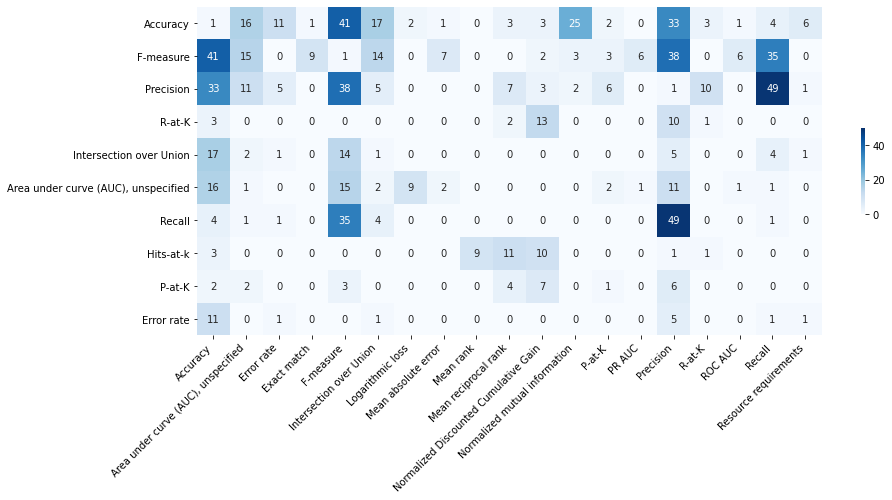

In [87]:
plt.figure(figsize = (14,16))
annot_kws = {"ha": 'center',"va": 'center'}
g = sns.heatmap(cooccurrence_matrix_filtered.T, square=True, cbar_kws={"shrink": .1}, vmax=50, cmap='Blues', annot=True, fmt='g', annot_kws=annot_kws)
g.set_ylim(10, 0)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')


# Save figure
plt.savefig('plots/coocurrence_matrix_for_classification_metrics.png', format='png')

#### NLP metrics

In [88]:
nlp_metrics = top_level_metrics_per_benchmark_nlp.performance_measure_label[0:10].to_list()
print(nlp_metrics)

different_metrics_per_benchmark_superproperties_distinct = number_of_different_metrics_per_benchmark_superproperties_distinct['performance_measure_labels'].str.split(";", expand = True)
different_metrics_per_benchmark_superproperties_one_hot = pd.get_dummies(different_metrics_per_benchmark_superproperties_distinct, prefix='', prefix_sep='').groupby(level=0, axis=1).sum()
cooccurrence_matrix_filtered = different_metrics_per_benchmark_superproperties_one_hot.T.dot(different_metrics_per_benchmark_superproperties_one_hot)
cooccurrence_matrix_filtered .values[[np.arange(cooccurrence_matrix_filtered.shape[0])]*2] = 1
cooccurrence_matrix_filtered = cooccurrence_matrix_filtered.filter(items=nlp_metrics)
cooccurrence_matrix_filtered = cooccurrence_matrix_filtered[(cooccurrence_matrix_filtered.T >= 1).any()]
cooccurrence_matrix_filtered = cooccurrence_matrix_filtered.drop(index='Undetermined')

['BLEU score', 'ROUGE metric', 'Perplexity', 'METEOR', 'Word Error Rate', 'Exact match', 'Consensus-based Image Description Evaluation', 'Unlabeled attachment score', 'Labeled attachment score', 'Bit per character']


<ipython-input-88-7beb2b0528b6>:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cooccurrence_matrix_filtered .values[[np.arange(cooccurrence_matrix_filtered.shape[0])]*2] = 1


In [89]:
# Remove 'NEW' string from performance_measure_label column for plotting
edited_strings_rows = [i.rstrip(' NEW') for i in cooccurrence_matrix_filtered.index]
cooccurrence_matrix_filtered = cooccurrence_matrix_filtered.set_index([edited_strings_rows])

#edited_strings_columns = [i.rstrip(' NEW') for i in cooccurrence_matrix_filtered.columns]
#cooccurrence_matrix_filtered.columns = edited_strings_columns
#cooccurrence_matrix_filtered


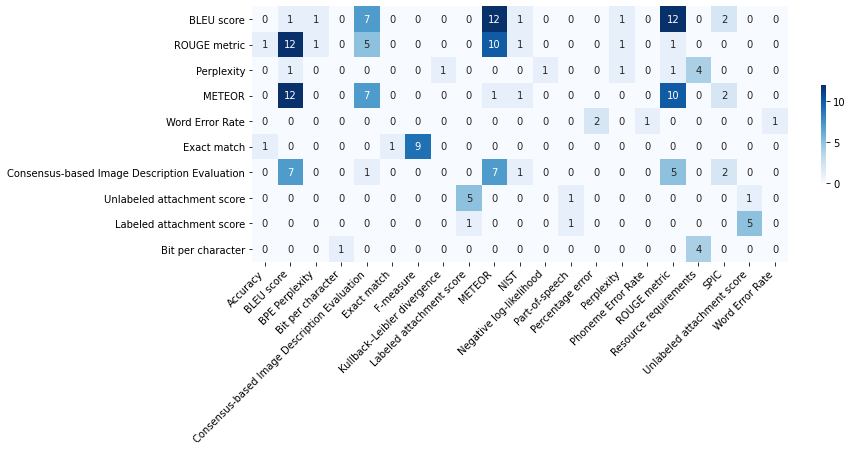

In [90]:
plt.figure(figsize = (12,18))
annot_kws = {"ha": 'center',"va": 'center'}
g = sns.heatmap(cooccurrence_matrix_filtered.T[0:10], square=True, cbar_kws={"shrink": .1}, cmap='Blues', annot=True, annot_kws=annot_kws)
g.set_ylim(10.0, 0)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')


# Save figure
plt.savefig('plots/coocurrence_matrix_for_nlp_metrics.png', format='png')

### Which metrics appear in  isolation?

In [95]:
cooccurrence_matrix_zero_entries = (cooccurrence_matrix != 0).any()
#print(cooccurrence_matrix_zero_entries)
lone_metrics = list(cooccurrence_matrix_zero_entries[cooccurrence_matrix_zero_entries != True].index)

lone_metrics

['Absolute relative error',
 'Angular Error',
 'Average 3D Error',
 'Average End-point Error',
 'Average Success Rate',
 'Average Treatment Effect Error',
 'Average classification error rate',
 'Average daily returns',
 'Bit per character',
 'Bits per sub-pixel',
 'CREMI Score',
 'Chamfer Distance',
 'Classification Error',
 'Color peak signal-to-noise ratio',
 'Consistency',
 'Cross View Ground Truth Consistency Error',
 'Cumulative regret',
 'Damerau–Levenshtein distance',
 'Diacritic Error Rate',
 'Diversity',
 'ELO Rating',
 'Energy above hull',
 'Error',
 'Expected average overlap',
 'FPR-at-K',
 'Final Displacement Error',
 'Final agent reward',
 'Genuine Acceptance Rate',
 'Ground Truth Error',
 'Image quality',
 'Integrated root mean-square deviation',
 'Intensive Care After Thrombolysis Score',
 'Interest',
 'Interpolation Error',
 'Kernel Inception Distance',
 'L1',
 'L2',
 'Labeled attachment score',
 'Log-Spectral Distance',
 'Log-likelihood',
 'MACE',
 'Mean Reconstruction

### Statistics per top-level metric type

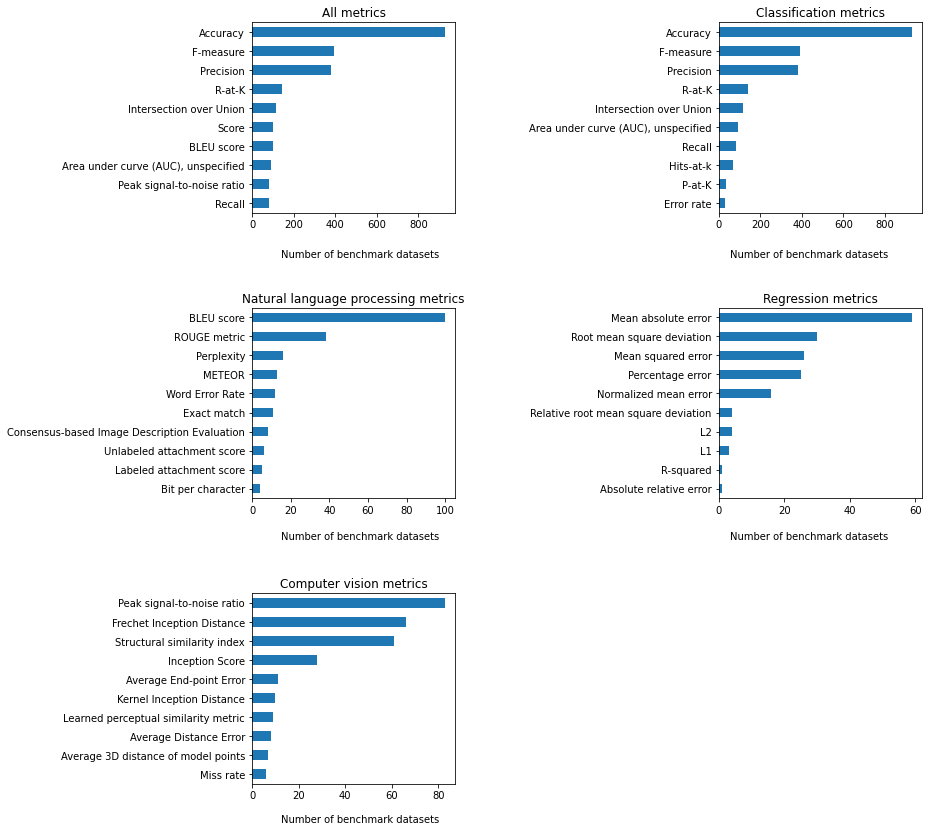

In [96]:
fig, axes = plt.subplots(figsize=(12,14), nrows=3, ncols=2)
fig.subplots_adjust(wspace = 1.3, hspace=0.5)

#frequency_per_task_type.sort_values(by='Fraction', ascending=True).plot.barh(ax=axes[0,0], rot=0, legend=None)
top_level_metrics_per_benchmark_and_associated_tasks.head(10).sort_values(by='benchmark_count').plot.barh(x='performance_measure_label', y='benchmark_count', ax=axes[0,0], rot=0, legend=None)
top_level_metrics_per_benchmark_classification[0:10].sort_values(by='benchmark_count', ascending=True).plot.barh(x='performance_measure_label', y='benchmark_count', ax=axes[0,1], legend=None)
top_level_metrics_per_benchmark_nlp[0:10].sort_values(by='benchmark_count', ascending=True).plot.barh(x='performance_measure_label', y='benchmark_count', ax=axes[1,0], legend=None)
top_level_metrics_per_benchmark_regression[0:10].sort_values(by='benchmark_count', ascending=True).plot.barh(x='performance_measure_label', y='benchmark_count', ax=axes[1,1], legend=None)
top_level_metrics_per_benchmark_computer_vision[0:10].sort_values(by='benchmark_count', ascending=True).plot.barh(x='performance_measure_label', y='benchmark_count', ax=axes[2,0], legend=None)

fig.text(0.25,0.09, "Number of benchmark datasets", ha="center", va="center")
#fig.text(0.77,0.09, "Number of benchmark datasets", ha="center", va="center")
fig.text(0.25,0.37, "Number of benchmark datasets", ha="center", va="center")
fig.text(0.77,0.37, "Number of benchmark datasets", ha="center", va="center")
fig.text(0.25,0.65, "Number of benchmark datasets", ha="center", va="center")
fig.text(0.77,0.65, "Number of benchmark datasets", ha="center", va="center")
axes[0,0].title.set_text('All metrics')
axes[0,1].title.set_text('Classification metrics')
axes[1,0].title.set_text('Natural language processing metrics')
axes[1,1].title.set_text('Regression metrics')
axes[2,0].title.set_text('Computer vision metrics')

axes[2,1].set_visible(False)

axes[0,1].yaxis.set_label_text("")
axes[1,0].yaxis.set_label_text("")
axes[1,1].yaxis.set_label_text("")
axes[2,0].yaxis.set_label_text("")
axes[0,0].yaxis.set_label_text("")


# Save figure
plt.savefig('plots/statistics_per_toplevel_metric_type.png', format='png')

## Statistics on submetrics

### Total reports per submetric

In [97]:
qs = """
SELECT ?performance_measure_label ?performance_measure
       (COUNT(?benchmark_process_indivdual_in_subproperty) AS ?benchmark_process_individual_in_subproperty_count)
WHERE {
    ?performance_measure rdfs:subPropertyOf ito:performance_measure ;
                         rdfs:label ?performance_measure_label .
    ?performance_measure_subproperty rdfs:subPropertyOf* ?performance_measure .
    ?benchmark_process_indivdual_in_subproperty ?performance_measure_subproperty ?result_s .
}

GROUP BY ?performance_measure_label ?performance_measure
ORDER BY DESC(?benchmark_process_individual_in_subproperty_count)
"""

subproperty_statistics = query(endpoint, prefixes + qs, ['benchmark_process_individual_in_subproperty_count'])
# save to csv
subproperty_statistics.to_csv(os.path.join(DATA_DIR, 'total_reports_per_submetric.csv'), index=False)

subproperty_statistics.head()

,performance_measure_label,performance_measure,benchmark_process_individual_in_subproperty_count
0,Accuracy,https://identifiers.org/ito#ITO_01157,12061
1,Score,https://identifiers.org/ito#ITO_08816,3752
2,Precision,https://identifiers.org/ito#ITO_04547,3526
3,F-measure,https://identifiers.org/ito#ITO_01609,2115
4,Peak signal-to-noise ratio,https://identifiers.org/ito#ITO_00016,944


In [98]:
subproperty_statistics.shape

(182, 3)

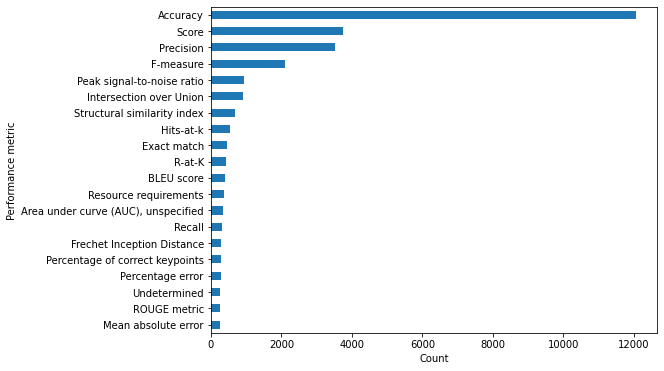

In [99]:
ax = subproperty_statistics.head(20).sort_values(by='benchmark_process_individual_in_subproperty_count').plot.barh(x='performance_measure_label', y='benchmark_process_individual_in_subproperty_count', figsize=(8, 6), legend=None)
ax.set(ylabel='Performance metric', xlabel='Count')

# Save figure
plt.savefig('plots/total_reports_per_submetric.png', format='png')

### Total reports per submetric and distinct benchmark

In [100]:
qs = """
SELECT ?performance_measure_label ?performance_measure
       (COUNT(?benchmark_process_indivdual) AS ?benchmark_process_indivdual_count)
WHERE {
    ?performance_measure rdfs:subPropertyOf* ito:performance_measure ;
                         rdfs:label ?performance_measure_label .
    ?benchmark_process_indivdual ?performance_measure ?result .
}
GROUP BY ?performance_measure_label ?performance_measure
ORDER BY DESC(?benchmark_process_indivdual_count)
"""

direct_property_statistics = query(endpoint, prefixes + qs, ['benchmark_process_indivdual_count'])
# save to csv
direct_property_statistics.to_csv(os.path.join(DATA_DIR, 'total_reports_per_submetric_and_distinct_benchmark.csv'), index=False)

direct_property_statistics.head()

,performance_measure_label,performance_measure,benchmark_process_indivdual_count
0,Accuracy,https://identifiers.org/ito#ITO_02411,5284
1,Score,https://identifiers.org/ito#ITO_08816,3742
2,Accuracy (CS),https://identifiers.org/ito#ITO_06723,1230
3,Accuracy (CV),https://identifiers.org/ito#ITO_06722,1107
4,F1,https://identifiers.org/ito#ITO_03697,985


In [101]:
direct_property_statistics['benchmark_process_indivdual_count'].sum()

32209

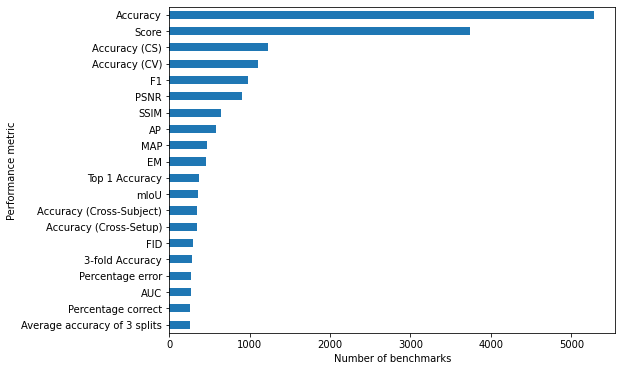

In [102]:
ax = direct_property_statistics.head(20).sort_values(by='benchmark_process_indivdual_count').plot.barh(x='performance_measure_label', y='benchmark_process_indivdual_count', rot=0, figsize=(8, 6), legend=False)
ax.set(ylabel='Performance metric', xlabel='Number of benchmarks')

# Save figure
plt.savefig('plots/total_reports_per_submetric_and_distinct_benchmark_dataset.png', format='png')

### Number of benchmark datasets per submetric

In [103]:
qs = """
SELECT ?performance_measure_label ?performance_measure
       (COUNT(?benchmark) AS ?benchmark_count)
WHERE {
    ?performance_measure rdfs:subPropertyOf* ito:performance_measure ;
                         rdfs:label ?performance_measure_label .
    ?benchmark rdfs:subClassOf ?property_restriction .
    ?property_restriction owl:onProperty ?performance_measure
}
GROUP BY ?performance_measure_label ?performance_measure
ORDER BY DESC(?benchmark_count)
"""


direct_property_statistics_per_benchmark = query(endpoint, prefixes + qs, ['benchmark_count'])
# save to csv
direct_property_statistics_per_benchmark.to_csv(os.path.join(DATA_DIR, 'number_of_benchmark_datasets_per_submetric.csv'), index=False)

direct_property_statistics_per_benchmark.head()

,performance_measure_label,performance_measure,benchmark_count
0,Accuracy,https://identifiers.org/ito#ITO_02411,583
1,F1,https://identifiers.org/ito#ITO_03697,137
2,Score,https://identifiers.org/ito#ITO_08816,98
3,AP,https://identifiers.org/ito#ITO_02616,78
4,AUC,https://identifiers.org/ito#ITO_02593,75


In [104]:
direct_property_statistics_per_benchmark['benchmark_count'].sum()

3664

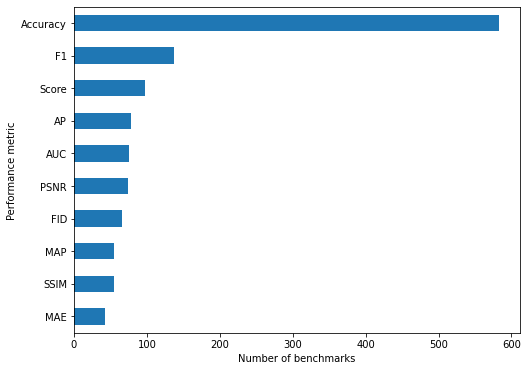

In [105]:
ax = direct_property_statistics_per_benchmark.head(10).sort_values(by='benchmark_count').plot.barh(x='performance_measure_label', y='benchmark_count', rot=0, figsize=(8, 6), legend=None)
ax.set(ylabel='Performance metric', xlabel='Number of benchmarks')

# Save figure
plt.savefig('plots/number_of_benchmark_datasets_per_submetric.png', format='png')

### Number of different submetrics per benchmark

In [106]:
qs = """
SELECT ?benchmark_label ?benchmark
       (COUNT(DISTINCT?performance_measure) AS ?performance_measure_count)
       (GROUP_CONCAT(DISTINCT ?performance_measure_label;SEPARATOR=";") AS ?performance_measure_labels)
WHERE {
    ?performance_measure rdfs:subPropertyOf* ito:performance_measure ;
                         rdfs:label ?performance_measure_label .
    ?benchmark rdfs:subClassOf ito:Benchmarking ;
              rdfs:label ?benchmark_label ;
              rdfs:subClassOf ?property_restriction .
    ?property_restriction owl:onProperty ?performance_measure .
}
GROUP BY ?benchmark_label ?benchmark
ORDER BY DESC(?performance_measure_count)
"""

number_of_different_metrics_per_benchmark = query(endpoint, prefixes + qs, ['performance_measure_count'])
# save to csv
number_of_different_metrics_per_benchmark.to_csv(os.path.join(DATA_DIR, 'number_of_different_submetrics_per_benchmark.csv'), index=False)

number_of_different_metrics_per_benchmark.head()

,benchmark_label,benchmark,performance_measure_count,performance_measure_labels
0,MSR-VTT - Video Retrieval benchmarking,https://identifiers.org/ito#ITO_07273,10,text-to-video Median Rank;text-to-video R-at-1...
1,COCO test-dev - Keypoint Detection benchmarking,https://identifiers.org/ito#ITO_11334,10,APL;AP50;AP75;AP;APM;AR;AR50;AR75;ARL;ARM
2,RCV1 - Text Classification benchmarking,https://identifiers.org/ito#ITO_14703,9,P-at-1;P-at-5;nDCG-at-5;nDCG-at-3;nDCG-at-1;P-...
3,"MIT-States, generalized split - Compositional ...",https://identifiers.org/ito#ITO_07763,9,Test AUC top 2;Val AUC top 3;Test AUC top 1;Te...
4,COCO test-challenge - Keypoint Detection bench...,https://identifiers.org/ito#ITO_11367,9,APL;AP50;AP75;AP;AR;AR50;AR75;ARL;ARM


In [107]:
number_of_different_metrics_per_benchmark_grouped = number_of_different_metrics_per_benchmark.groupby('performance_measure_count').size()
#number_of_different_metrics_per_benchmark_grouped

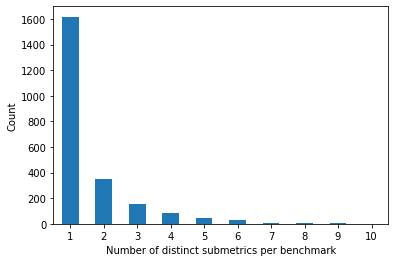

In [108]:
ax = number_of_different_metrics_per_benchmark_grouped.plot.bar(x='high_level_process_label', y='subprocess_performance_measure_count', rot=0, figsize=(6, 4))
ax.set(ylabel='Count', xlabel='Number of distinct submetrics per benchmark')

# Save figure
plt.savefig('plots/number_of_distinct_submetrics_per_benchmark.png', format='png')

### Co-occurrence matrix

In [109]:
different_metrics_per_benchmark = number_of_different_metrics_per_benchmark['performance_measure_labels'].str.split(";", expand = True)
different_metrics_per_benchmark_one_hot = pd.get_dummies(different_metrics_per_benchmark, prefix='', prefix_sep='').groupby(level=0, axis=1).sum()

cooccurrence_matrix = different_metrics_per_benchmark_one_hot.T.dot(different_metrics_per_benchmark_one_hot)
cooccurrence_matrix .values[[np.arange(cooccurrence_matrix .shape[0])]*2] = 0
cooccurrence_matrix


<ipython-input-109-8d660cb85961>:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cooccurrence_matrix .values[[np.arange(cooccurrence_matrix .shape[0])]*2] = 0


,# of clusters (k),% Test Accuracy,% Train Accuracy,1 in 10 R-at-1,1 in 10 R-at-2,1 in 10 R-at-5,1 in 2 R-at-1,1-of-100 Accuracy,10 fold Cross validation,10%,...,text-to-video R-at-5,text-to-video R-at-50,three pixel error,training time (s),v2v error,video-to-text Mean Rank,video-to-text Median Rank,video-to-text R-at-1,video-to-text R-at-10,video-to-text R-at-5
# of clusters (k),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
% Test Accuracy,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
% Train Accuracy,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1 in 10 R-at-1,0,0,0,0,2,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1 in 10 R-at-2,0,0,0,2,0,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
video-to-text Mean Rank,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,1,1,1
video-to-text Median Rank,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,1,1
video-to-text R-at-1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,1,1
video-to-text R-at-10,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,1,0,1


### Which metrics appear in  isolation?

In [110]:
cooccurrence_matrix_zero_entries = (cooccurrence_matrix != 0).any()
#print(cooccurrence_matrix_zero_entries)
lone_metrics = list(cooccurrence_matrix_zero_entries[cooccurrence_matrix_zero_entries != True].index)
#lone_metrics

## Plot both count of distinct super-properties and sub-properties together

In [111]:
number_of_different_metrics_per_benchmark_superproperties_distinct_grouped

distinct_performance_measure_count
1    1777
2     345
3     132
4      33
5       9
6       2
dtype: int64

In [112]:
number_of_different_metrics_per_benchmark_grouped

performance_measure_count
1     1617
2      350
3      152
4       87
5       43
6       32
7        7
8        5
9        3
10       2
dtype: int64

distinct_performance_measure_count
1    1777
2     345
3     132
4      33
5       9
6       2
dtype: int64


[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Number of distinct performance metrics per benchmark dataset')]

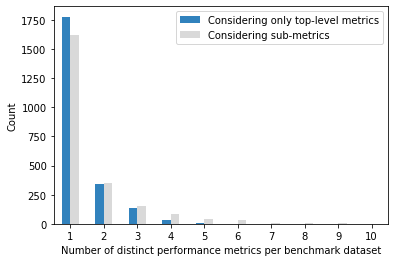

In [113]:
# Extend series with missing values for plotting
missing_values = set(number_of_different_metrics_per_benchmark_grouped.index).difference(set(number_of_different_metrics_per_benchmark_superproperties_distinct_grouped.index))
missing_values_series = pd.Series([0 for x in missing_values], index=missing_values)
number_of_different_metrics_per_benchmark_superproperties_distinct_grouped_extended = number_of_different_metrics_per_benchmark_superproperties_distinct_grouped.append(missing_values_series)
print(number_of_different_metrics_per_benchmark_superproperties_distinct_grouped)
index = number_of_different_metrics_per_benchmark_grouped.index
df = pd.DataFrame({'Considering only top-level metrics': number_of_different_metrics_per_benchmark_superproperties_distinct_grouped_extended.values, 'Considering sub-metrics': number_of_different_metrics_per_benchmark_grouped.values}, index=index)
ax = df.plot.bar(rot=0, cmap='tab20c')
ax.set(ylabel='Count', xlabel='Number of distinct performance metrics per benchmark dataset')

## Metrics per benchmark

In [114]:
number_of_different_metrics_per_benchmark_superproperties_distinct.head()

,benchmark_label,benchmark,performance_measure_count,performance_measure_labels,distinct_performance_measure_count
27,NTU Hand Digit - Gesture-to-Gesture Translatio...,https://identifiers.org/ito#ITO_11038,6,Peak signal-to-noise ratio;Inception Score;Und...,6
26,Senz3D - Gesture-to-Gesture Translation benchm...,https://identifiers.org/ito#ITO_11027,6,Peak signal-to-noise ratio;Inception Score;Und...,6
50,E2E NLG Challenge - Data-to-Text Generation be...,https://identifiers.org/ito#ITO_09083,5,METEOR;NIST;Consensus-based Image Description ...,5
34,S3DIS - 3D Instance Segmentation benchmarking,https://identifiers.org/ito#ITO_16148,6,Intersection over Union;Recall;Precision;Accur...,5
17,ImageNet 64x64 - Image Generation benchmarking,https://identifiers.org/ito#ITO_05884,6,Bits per byte;Inception Score;Bits per dimensi...,5


In [115]:
print('Mean: {}'.format(np.mean(number_of_different_metrics_per_benchmark_superproperties_distinct.distinct_performance_measure_count)))
print('Median: {}'.format(np.median(number_of_different_metrics_per_benchmark_superproperties_distinct.distinct_performance_measure_count)))
print('Max: {}'.format(np.max(number_of_different_metrics_per_benchmark_superproperties_distinct.distinct_performance_measure_count)))
print('Min: {}'.format(np.min(number_of_different_metrics_per_benchmark_superproperties_distinct.distinct_performance_measure_count)))

Mean: 1.3281114012184507
Median: 1.0
Max: 6
Min: 1


## Additional statistics

### Which NLP tasks are NLP-specific metrics used for?

In [116]:
df = pd.concat([number_of_different_metrics_per_benchmark_superproperties.iloc[:,0:1],number_of_different_metrics_per_benchmark_superproperties['performance_measure_labels'].str.split(";", expand = True)], axis=1)

In [117]:
nlp_metrics

['BLEU score',
 'ROUGE metric',
 'Perplexity',
 'METEOR',
 'Word Error Rate',
 'Exact match',
 'Consensus-based Image Description Evaluation',
 'Unlabeled attachment score',
 'Labeled attachment score',
 'Bit per character']

In [118]:
df = df[(df[0]).isin(nlp_metrics) | (df[1].isin(nlp_metrics)) | (df[2].isin(nlp_metrics)) | (df[3].isin(nlp_metrics))| (df[4].isin(nlp_metrics))| (df[5].isin(nlp_metrics))]
set(df.benchmark_label)

{'20NEWS - Topic Models benchmarking',
 'ACCURAT balanced test corpus for under resourced languages Estonian-Russian - Machine Translation benchmarking',
 'ACCURAT balanced test corpus for under resourced languages Russian-Estonian - Machine Translation benchmarking',
 'ACL Title and Abstract Dataset - Paper generation benchmarking',
 'ASLG-PC12 - Sign Language Translation benchmarking',
 'ActivityNet Captions - Dense Video Captioning benchmarking',
 'Android Repos - Code Generation benchmarking',
 'CHiME-4 real 6ch - Distant Speech Recognition benchmarking',
 'CMU-SE - Text Generation benchmarking',
 'CMUDict 0.7b - Text-To-Speech Synthesis benchmarking',
 'CNN / Daily Mail - Abstractive Text Summarization benchmarking',
 'CNN / Daily Mail - Document Summarization benchmarking',
 'CNN / Daily Mail - Extractive Document Summarization benchmarking',
 'CNN / Daily Mail - Question Answering benchmarking',
 'COCO - Image Captioning benchmarking',
 'COCO Captions - Text Generation benchmark

In [119]:
df.index = df.benchmark_label

In [120]:
pd.set_option('display.max_rows', None)
df_new = pd.get_dummies(df.iloc[:,1:], prefix='', prefix_sep='').groupby(level=0, axis=1).sum().filter(nlp_metrics)
df_new

,BLEU score,ROUGE metric,Perplexity,METEOR,Word Error Rate,Exact match,Consensus-based Image Description Evaluation,Unlabeled attachment score,Labeled attachment score,Bit per character
benchmark_label,,,,,,,,,,
COCO - Image Captioning benchmarking,1,1,0,1,0,0,1,0,0,0
Food.com - Recipe Generation benchmarking,1,1,0,0,0,0,0,0,0,0
E2E NLG Challenge - Data-to-Text Generation benchmarking,1,1,0,1,0,0,1,0,0,0
NarrativeQA - Question Answering benchmarking,1,1,0,1,0,0,0,0,0,0
Flickr30k Captions test - Image Captioning benchmarking,1,0,0,1,0,0,1,0,0,0
COCO Captions test - Image Captioning benchmarking,1,0,0,1,0,0,1,0,0,0
MSR-VTT - Video Captioning benchmarking,1,1,0,1,0,0,1,0,0,0
MSVD - Video Captioning benchmarking,1,1,0,1,0,0,1,0,0,0
VATEX - Video Captioning benchmarking,1,1,0,1,0,0,1,0,0,0


### How often do BLEU variants appear?

In [121]:
bleu_variants = ['BLEU', 'BLEU score', 'BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'BLEU-5', 'SacreBLEU']
bleu_variants_df = direct_property_statistics_per_benchmark[direct_property_statistics_per_benchmark.performance_measure_label.isin(bleu_variants)]
bleu_variants_df

,performance_measure_label,performance_measure,benchmark_count
12,BLEU,https://identifiers.org/ito#ITO_05183,37
22,BLEU score,https://identifiers.org/ito#ITO_05202,21
30,BLEU-4,https://identifiers.org/ito#ITO_08345,17
72,BLEU-1,https://identifiers.org/ito#ITO_08190,8
82,BLEU-3,https://identifiers.org/ito#ITO_09003,7
123,BLEU-2,https://identifiers.org/ito#ITO_09002,5
188,SacreBLEU,https://identifiers.org/ito#ITO_05304,3
242,BLEU-5,https://identifiers.org/ito#ITO_09004,2


### How often is ROUGE used in isolation?

In [122]:
number_of_different_metrics_per_benchmark_superproperties['performance_measure_labels'].str.contains('ROUGE metric').value_counts()

False    2274
True       24
Name: performance_measure_labels, dtype: int64

In [123]:
number_of_different_metrics_per_benchmark_superproperties.query('performance_measure_labels == "ROUGE metric"').count()

benchmark_label               9
benchmark                     9
performance_measure_count     9
performance_measure_labels    9
dtype: int64

### Metrics

In [124]:
print('Count of performance metrics before manual curation: {}'.format(direct_property_statistics_per_benchmark.shape[0]))
print('Count of performance metrics after manual assignment to super classes: {}'.format(subproperty_statistics.shape[0]))
print('Number of metrics that could not be assigned (\'Undetermined\'): 271')

Count of performance metrics before manual curation: 811
Count of performance metrics after manual assignment to super classes: 182
Number of metrics that could not be assigned ('Undetermined'): 271
